# Задание

В данном задании необходимо кластеризовать изображения из двух разных датасетов (Mnist и Fashion Mnist). Чтобы это осуществить, мы воспользуемся автоэнкодером, который позволит получить векторные представления (эмбеддинги) изображений.

**Часть 1**

1. Загрузите изображения из датасетов Mnist и Fashion Mnist (можно использовать только изображения из обучающей части выборок), объедините их в один массив.
2. Сделайте необходимую предобработку данных (нормализацию и приведение к нужной размерности для подачи в автоэнкодер).
3. Создайте модель автоэнкодера, обучите ее в течение 10 эпох на сформированной выборке (содержащей изображения цифр и предметов одежды).
4. Перемешайте выборку и извлеките из нее 2000 случайных изображений, они будут использоваться для кластеризации. Получите векторные представления этих изображений с помощью энкодера.
5. Проведите серию экспериментов по кластеризации векторных представлений отобранных изображений с использованием алгоритма `KMeans`:
- протестируйте разное число кластеров (2, 5, 10, 20 и 30),
- для каждого эксперимента посчитайте значение метрики качества кластеризации `sklearn.metrics.silhouette_score`, запишите его в таблицу,
- для каждого эксперимента выведите двумерные представления изображений на график, цвет точки должен показывать принадлежность к кластеру, к которому изображение было отнесено.

Должен получиться примерно следующий результат:

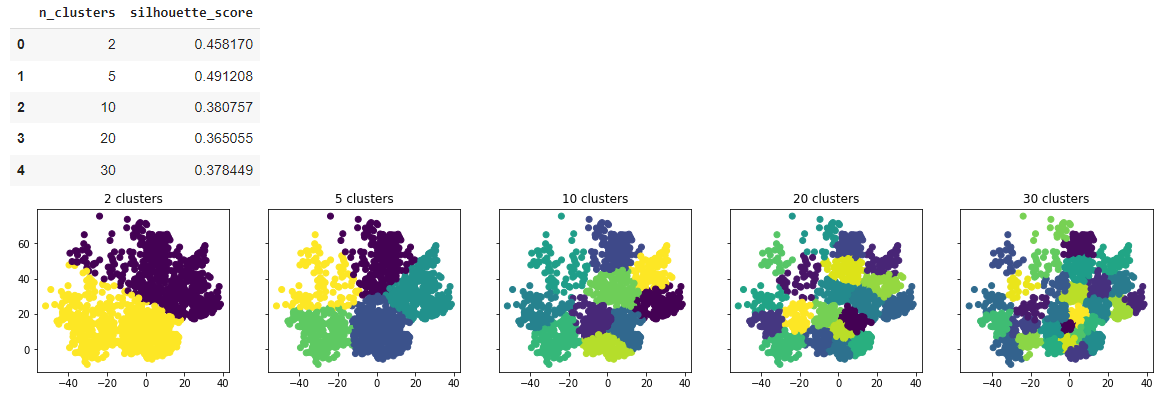

**Часть 2**

1. Возьмите разбиение всех изображений на 30 кластеров.
2. Выведите 10 случайных изображений из одного кластера (любого).
3. Выведите 2 "наиболее удаленных" друг от друга изображения из этого же кластера (т.е. расстояние между векторными представлениями которых максимально в рамках текущего кластера).

**Импорты**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose
from sklearn.metrics import silhouette_score, pairwise_distances

**Примеры кода**

Код для создания модели-автоэнкодера

In [ ]:
# Создадим функцию сборки блока построения сверточного энкодера
def encoderBlock(xin,        # Входной тензор
                 neu=8,      # Число нейронов сверточного слоя
                 kernel=3,   # Размер ядра сверточного слоя
                 strides=1): # Число шагов сверточного слоя

    # Составим блок сети
    x = Conv2D(neu, kernel_size=kernel, strides= strides, padding='same')(xin) # Добавим 2D свертку
    x = BatchNormalization()(x)                                                # Добавим нормализацию по батчу
    x = LeakyReLU()(x)                                                         # Добавим функцию активации

    # Вернем выходной тензор
    return x


# Создадим функцию сборки блока построения сверточного декодера
def decoderBlock(xin,        # Входной тензор
                 neu=8,      # Число нейронов сверточного слоя
                 kernel=3,   # Размер ядра сверточного слоя
                 strides=1): # Число шагов сверточного слоя

    # Составим блок сети
    x = Conv2DTranspose(neu, kernel_size=kernel, strides= strides, padding='same')(xin)  # Добавим обратную 2D свертку
    x = BatchNormalization()(x)                                                          # Добавим нормализацию по батчу
    x = LeakyReLU()(x)                                                                   # Добавим функцию активации

    # Вернем выходной тензор
    return x


# Создадим функцию сборки автоэнкодера, которая будет возвращать всю модель и энкодер отдельно
# latent_dim - длина вектора скрытого представления в автокодировщике
def create_encoder(latent_dim):
    
    # Создадим сверточный энкодер
    input_img = Input(shape=(28, 28, 1))                     # Добавим входной слой
    x = encoderBlock(input_img, neu=16, kernel=3, strides=1) # Добавим 1-й блок
    x = encoderBlock(x, neu=32, kernel=3, strides=2)         # Добавим 2-й блок
    flatten =Flatten()(x)                                    # Добавим Flatten
    encoded = Dense(latent_dim, activation='linear')(flatten)# Добавим выходной dense слой

    # Создадим сверточный декодер
    input_enc = Input(shape=(latent_dim,))                   # Добавим входной слой
    x = Dense(3136, name='dense_1')(input_enc)               # Добавим Dense-слой c 7х7х64 = 3136 нейронами
    x = Reshape((7, 7, 64))(x)                               # Решейпим 1D тензор в 3D тензор
    x = decoderBlock(x, neu=32, kernel=3, strides=1)         # Добавим 1-й блок
    x = decoderBlock(x, neu=16, kernel=3, strides=2)         # Добавим 2-й блок
    x = decoderBlock(x, neu=16, kernel=3, strides=2)         # Добавим 3-й блок
    decoded = Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(x) # Добавим выходной слой

    # Соберем энкодер, декодер и автокодировщик
    encoderAEC = tf.keras.Model(input_img, encoded, name="encoder")                                     # Соберем энкодер
    decoderAEC = tf.keras.Model(input_enc, decoded, name="decoder")                                     # Соберем декодер
    autoencoder = tf.keras.Model(input_img, decoderAEC(encoderAEC(input_img)), name="autoencoder")      # Соберем автокодировщик
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')                                    # Скомпилируем автокодировщик

    return autoencoder, encoderAEC

**Решение**

In [ ]:
(X_train_fm, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()             # Загружаем датасет fashion mnist
(X_train_m, _), (_, _) = tf.keras.datasets.mnist.load_data()                      # Загружаем датасет mnist
X_train = np.concatenate([X_train_fm, X_train_m]).reshape(-1, 28, 28, 1) / 255.   # Объединяем изображения из загруженных датасетов + осуществляем нормировку и приведение к нужной размерности
np.random.shuffle(X_train)
X_for_clustering = X_train[:2000]

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
autoencoder, encoder = create_encoder(2)                                    # Создаем модели автоэнкодера и энкодера
autoencoder.fit(X_train, X_train, epochs=10, batch_size=64, shuffle=True)   # Обучаем автоэнкодер

Epoch 1/10
1875/1875 [==============================] - 18s 5ms/step - loss: 0.0520
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0459
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0441
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0431
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0425
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0420
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0416
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0413
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0411
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0409


,n_clusters,silhouette_score
0,2,0.432153
1,5,0.496571
2,10,0.384255
3,20,0.360198
4,30,0.385658


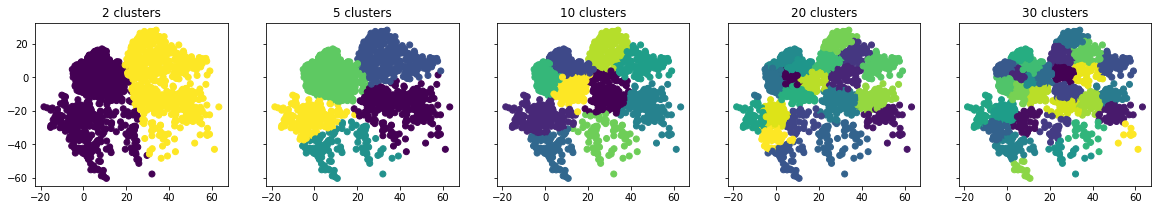

In [ ]:
results = []                                                    # Создаем список для хранения результатов экспериментов

fig, axes = plt.subplots(1, 5, figsize=(20, 3), sharey=True)    # Создаем 5 графиков

for idx, n_clusters in enumerate([2, 5, 10, 20, 30]):           # Проходим по списку с разными значениями числа кластеров + извлекаем индекс текущего элемента
  
  vectors = encoder.predict(X_for_clustering)                   # Получаем векторные представления отобранных изображений

  kmean = KMeans(n_clusters)                                    # Создаем объект KMeans с n_clusters кластерами
  labels = kmean.fit_predict(vectors)                           # Получаем метки кластеров для изображений
  score = silhouette_score(vectors, labels)                     # Рассчитываем значение метрики silhouette_score

  results.append([n_clusters, score])                           # Сохраняем значение метрики silhouette_score

  axes[idx].set_title(f'{n_clusters} clusters')                 # Задаем название графика
  axes[idx].scatter(vectors[:, 0], vectors[:, 1], c=labels)     # Выводим точки на график с учетом их предсказанной принадлежности к кластерам

pd.DataFrame(results, columns=['n_clusters', 'silhouette_score'])

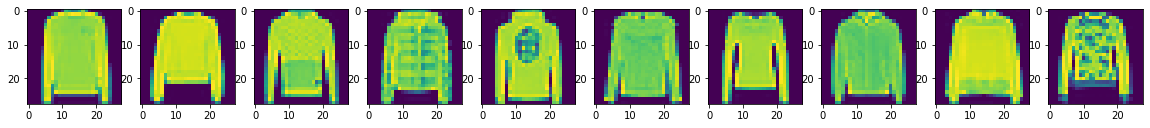

In [ ]:
cluster_num = 2                                                   # Выбираем индекс кластера
fig, axes = plt.subplots(1, 10, figsize=(20, 3))                  # Создаем 10 графиков
idxs = np.argwhere(labels == cluster_num).flatten().tolist()      # Извлекаем индексы изображений, принадлежащих к выбранному кластеру
for i in range(10):                                               # Извлекаем одно изображение по индексу и выводим его на график (повторяется 10 раз)
    img = X_for_clustering[idxs[i], ..., 0]                       
    axes[i].imshow(img)

In [ ]:
cluster_old_idxs = np.argwhere(labels == cluster_num).flatten()                                                       # Извлекаем индексы изображений, принадлежащих к выбранному кластеру
cluster_vectors = vectors[cluster_old_idxs]                                                                           # Извлекаем векторные представления изображений по отобранным индексам
dist_array = pairwise_distances(cluster_vectors)                                                                      # Рассчитываем попарные расстояния между векторными представлениями изображений
first_img_new_idx, second_img_new_idx = np.unravel_index(np.argmax(dist_array), dist_array.shape)                     # Находим пару индексов, соответствующую "наиболее удаленным" друг от друга изображениям
first_img_old_idx, second_img_old_idx = cluster_old_idxs[first_img_new_idx], cluster_old_idxs[second_img_new_idx]     # Находим соответствующие индексы в исходном массиве

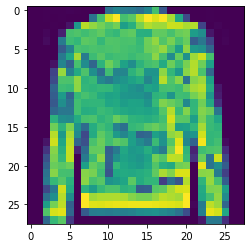

In [ ]:
plt.imshow(X_for_clustering[first_img_old_idx, ..., 0])                                                               # Выводим первое изображение

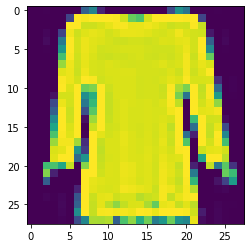

In [ ]:
plt.imshow(X_for_clustering[second_img_old_idx, ..., 0])                                                              # Выводим второе изображение